In [60]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.misc import imsave
%matplotlib inline

from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras import backend as K


In [2]:
NUM_CLASSES = 5
IMG_SIZE  = 224


In [3]:

def path_to_tensor(img_path):
    """
    read image data to the four dimensional tensor format required by keras 
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size = (IMG_SIZE, IMG_SIZE))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
#     x = (x - np.mean(x))/ np.std(x)
    x -= np.mean(x)
    x /= np.std(x)

    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis = 0)


def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm_notebook(img_paths)]
    
    return np.vstack(list_of_tensors)



In [4]:

def cnn_model():
    model = Sequential()
    
    # zero padding
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (IMG_SIZE, IMG_SIZE, 3), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = 'softmax'))
    
    return model


In [5]:

model = cnn_model()

model.load_weights('./models/2018-10-18_gps_model.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      36928     
__________

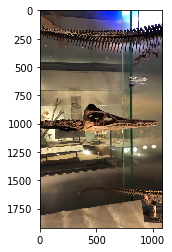

In [6]:
# prediction for one image

img_dir = ['/Users/yueying.teng/Documents/indoor_gps/sml_dataset/class_2/m4/output037.jpg']

# preprocess the image
test_img_array = paths_to_tensor(img_dir).astype(np.uint8)/ 255

# show the image
test_img = image.load_img(img_dir[0])
plt.imshow(test_img)


In [7]:
# get test image labels 

test_label_list = []
for i in range(len(img_dir)):
    start = img_dir[i].find('class')
    end = img_dir[i].find('/', start)

    test_label_list.append(img_dir[i][start+ 6: end])

# covnert string label to int 
test_label_list = [int(i) for i in test_label_list]


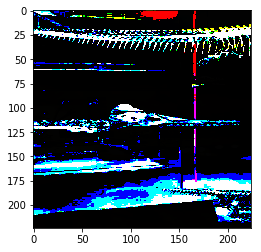

In [8]:
# show processed image
plt.imshow(test_img_array[0])


In [9]:
# prediction

pred = model.predict(test_img_array)
label_index = np.argmax(pred)
print("label index: ", label_index)


label index:  1


### visualize weights 

In [10]:
# first conv layer weights - weights and bias 

weights = model.get_layer('conv2d_1').get_weights()[0]
print(weights.shape)


(3, 3, 3, 32)


In [11]:

def display_images(images, titles = None, cols = 5, interpolation = None, cmap = "Greys_r"):
    """
    images: A list of images. it can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/ cols)
    height_ratio = 1.2 * (rows/ cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize = (15, 15 * height_ratio))

    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # If image is a list, merge them into one image.
        if type(image) is not np.ndarray:
            image = np.concatenate(image, axis = 1)

        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap = cmap, interpolation = interpolation)
        i += 1
        

In [12]:

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip image tensor to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x


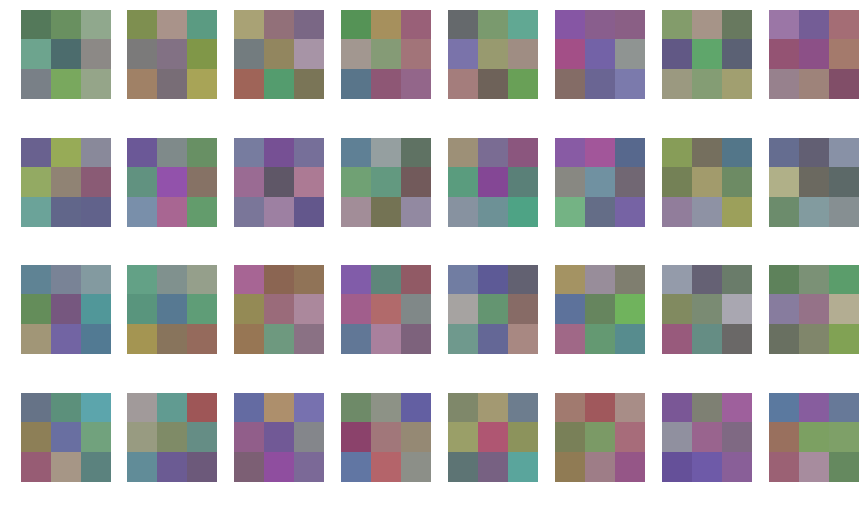

In [13]:
display_images([deprocess_image(weights[:, :, ::-1, i]) for i in range(32)], cols = 8, interpolation = "none")


### visualize activation 


In [14]:
def read_layer(model, test_img_array, layer_name):
    '''
    return activation values for the specified layer
    '''
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([test_img_array])[0]
    print(outputs.shape)
    
    # return the plotable image tensor 
    return outputs[0]


def view_layer(model, test_img_array, layer_name, cols = 5):
    outputs = read_layer(model, test_img_array, layer_name)
    display_images([outputs[:, :, i] for i in range(10)], cols = cols)

    

(1, 224, 224, 32)


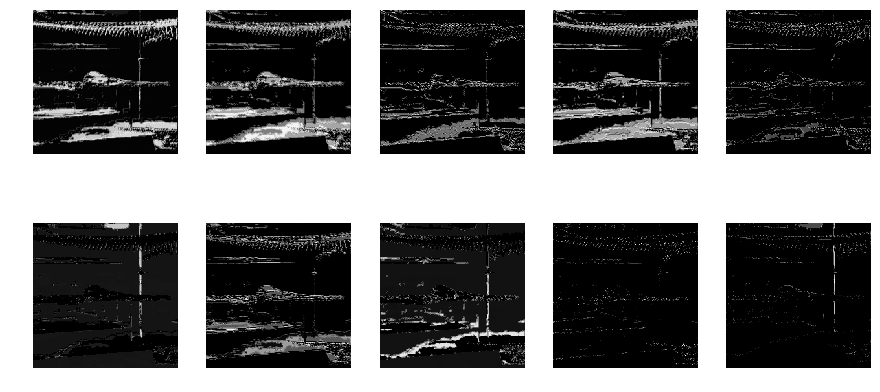

In [15]:
view_layer(model, test_img_array, 'conv2d_1')

(1, 222, 222, 32)


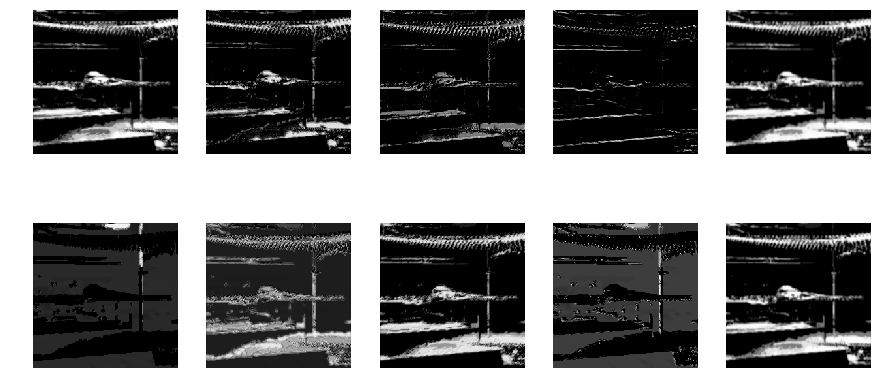

In [16]:
view_layer(model, test_img_array, 'conv2d_2')

(1, 109, 109, 64)


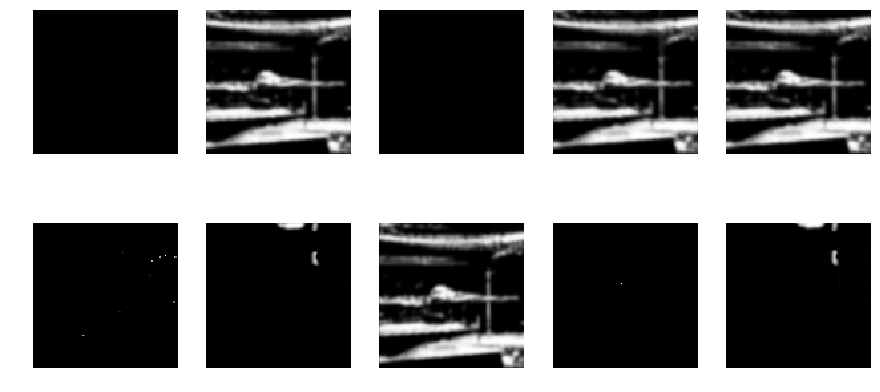

In [17]:
view_layer(model, test_img_array, 'conv2d_4')

(1, 52, 52, 128)


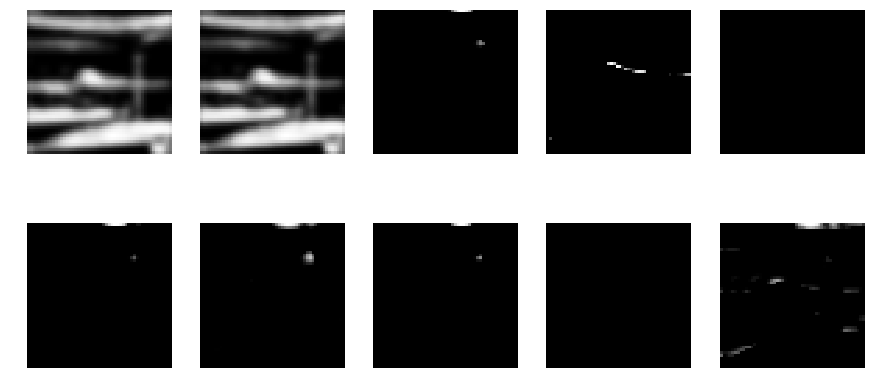

In [18]:
view_layer(model, test_img_array, 'conv2d_6')